In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [241]:
class HebianNet():
    def __init__(self):
        self.weights = None
        self.trained = False
        
    def train(self,data):
        ### Borde normera vikterna för att inte energin ska bli fuckad
        if not self.trained:
            self.weights = np.zeros((data.shape[1], data.shape[1]))
        for index in range(data.shape[0]):
            self.weights = np.add(np.outer(np.transpose(data[index,:]),data[index,:]),self.weights)
        self.weights = np.divide(self.weights, data.shape[1])
        self.trained = True
    
    def sparse_train(self, data, activity):
        activitiy = np.ones(data.shape)*activity
        data = data - activity
        self.train(data)
    
    def update_batch(self, x):
        new = np.dot(x,self.weights)
        new[new>=0] = 1
        new[new<0] = -1
        return new
    
    def update_asynch(self, x):
        dimension = x.shape[0]
        new = x.copy()
        for i in range(dimension):
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ < 0:
                new[i] = -1
            else:
                new[i] = 1
        return new

    def update_sparse(self, x, theta):
        dimension = x.shape[0]
        new = x.copy()
        for i in range(dimension):
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ - theta < 0:
                new[i] = 0
            else:
                new[i] = 1
        return new
    
    def update_random(self, x):
        dimension = x.shape[0]
        new = x.copy()
        for count in range(dimension):
            i = np.random.randint(0,dimension)
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ < 0:
                new[i] = -1
            else:
                new[i] = 1
        self.plot(new)
        return new        

    
    def recall(self, x, method = "batch", maxiter = None):
        error = 1
        itercount = 0
        
        if method == "batch":
            update = self.update_batch
        if method == "asynch":
            update = self.update_asynch
        if method == "random":
            update = self.update_random
        
        energy = []    
        while error > 0:
            new = update(x)
            error = sum(abs(new-x))
            x = new.copy()
            itercount += 1
            energy.append(self.energy(x))
            if itercount == maxiter:
                break
        return x, itercount, energy
    
    def energy(self, pattern):
        outer = np.outer(pattern, np.transpose(pattern))
        pos_energy = np.sum(np.multiply(self.weights, outer))
        return np.multiply(-1, pos_energy)
    
    def plot(self, pattern):
        plt.imshow(pattern.reshape(32,32),interpolation="nearest")
        plt.show()
        
        

In [162]:
mat = np.zeros((256, 8))
for i in range(256):
    arr = [int(x) for x in bin(i)[2:]]
    for j in range(len(arr)):
        mat[i][8 - len(arr) + j] = arr[j]

### Hopfield network recall

In [163]:
x1 = np.array([-1,-1,1,-1,1,-1,-1,1])
x2 = np.array([-1,-1,-1,-1,-1,1,-1,-1])
x3 = np.array([-1,1,1,-1,-1,1,-1,1])
data  = np.array([x1,x2,x3])

In [164]:
hn = HebianNet()

In [165]:
hn.train(data)

Reproduces learned patterns

In [166]:
np.count_nonzero(hn.update_batch(x1)-x1)

0

### Convergence and attractors

In [167]:
x1d = np.array([1,-1,1,-1,1,-1,-1,1])
x2d = np.array([1,1,-1,-1,-1,1,-1,-1])
x3d = np.array([1,1,1,-1,1,1,-1,1])

In [168]:
np.count_nonzero(hn.recall(x1d)[0]- x1)

0

hn.converge(x2d)[0] - x2

In [169]:
np.count_nonzero(hn.recall(x3d)[0] - x3)

0

Only x1d and x3d converge towards their respective undistorted patterns. x2d does not.

In [170]:
searchgrid = np.ones((256,8))

In [171]:
searchgrid

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

#### More than half wrong

In [172]:
x1dd = np.multiply(x1,np.array([-1,-1,-1,-1,-1,1,1,1]))

In [173]:
new, iterations, energy = hn.recall(x1dd)
new = np.multiply(new,x1).copy()
result = len(new[new<0])
print("Diff from original vector in {} elements. Number of iterations to convergance was {}".format(result,iterations))

Diff from original vector in 7 elements. Number of iterations to convergance was 2


## Picture Data

### Sequential Update

In [201]:
pictData = np.loadtxt('./pict.dat',delimiter=",", dtype=int).reshape(-1,1024)

In [202]:
trainingData = pictData[0:3].copy()

In [203]:
testData = pictData[3:].copy()

In [204]:
hn = HebianNet()

In [205]:
hn.train(trainingData)

#### Check stability of training patterns

In [179]:
test1 = np.multiply(hn.update_batch(trainingData[0]),trainingData[0])
print(len(test1[test1<0]))

0


In [180]:
test2 = np.multiply(hn.update_batch(trainingData[1]),trainingData[1])
print(len(test2[test2<0]))

0


In [181]:
test3 = np.multiply(hn.update_batch(trainingData[2]),trainingData[2])
print(len(test3[test3<0]))

0


#### Check performance on degraded patterns

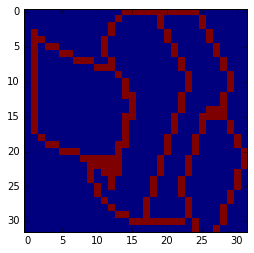

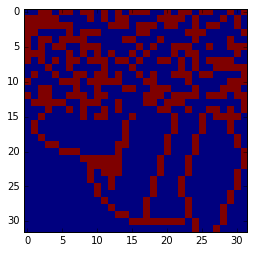

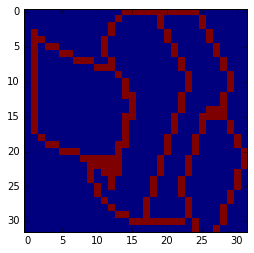

In [182]:
p10_recalled = hn.recall(testData[-2])[0]
#Plot picture 1
hn.plot(trainingData[0])
#Plot picture 10, degraded version of picture 1
hn.plot(testData[-2])
#Plot output of HebianNet on picture 11
hn.plot(p10_recalled)

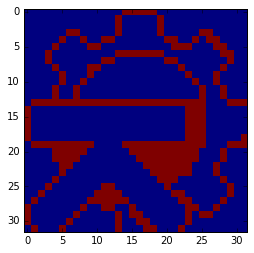

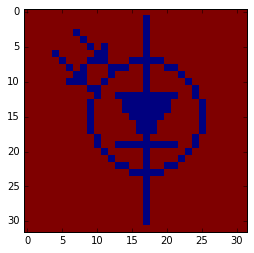

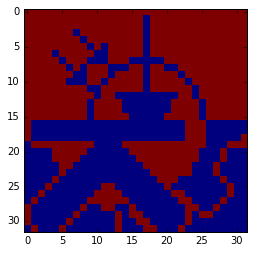

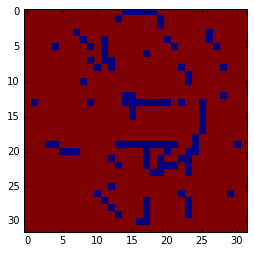

In [183]:
p11_recalled = hn.recall(testData[-1])[0]
#Show picture 2
hn.plot(trainingData[1])
#Show picture 3
hn.plot(trainingData[2])
#Show Picture 11, combination of 2 and 3
hn.plot(testData[-1])
#Show recalled version of picture 11
hn.plot(p11_recalled)

Diff from training pattern is 135
Number of iterations was 3


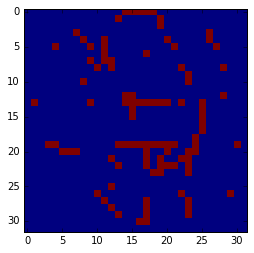

In [184]:
#Using "non - random" sequential updates
p10_arecalled, iter_, energy = hn.recall(testData[-2], method = 'asynch')
diff = np.multiply(p10_arecalled,trainingData[0])
print("Diff from training pattern is {}".format(len(diff[diff<0])))
print("Number of iterations was {}".format(iter_))
hn.plot(p10_arecalled)

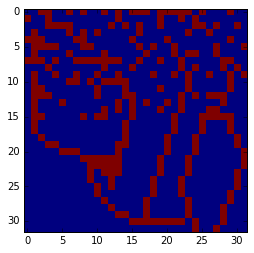

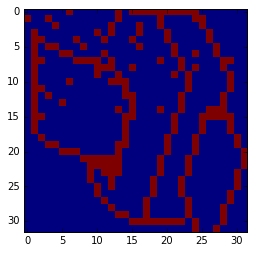

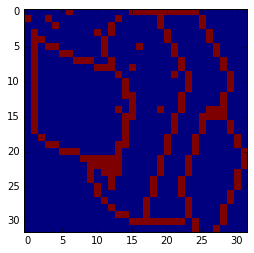

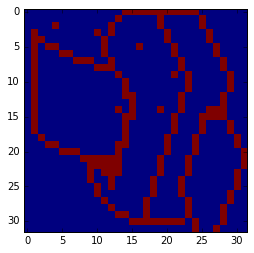

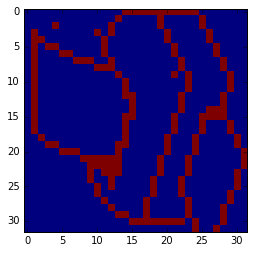

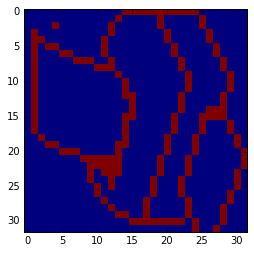

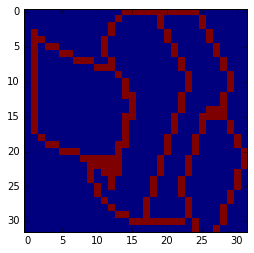

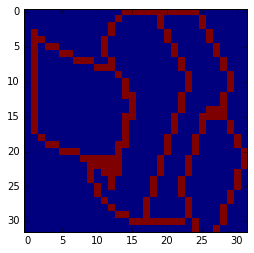

Diff from training pattern is 0
Number of iterations was 8


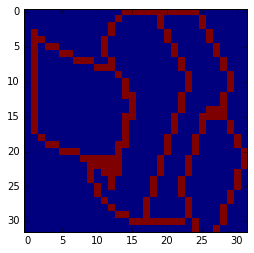

In [206]:
#Using random sequential updates
p10_arecalled, iter_, energy_random = hn.recall(testData[-2], method= 'random')
diff = np.multiply(p10_arecalled,trainingData[0])
print("Diff from training pattern is {}".format(len(diff[diff<0])))
print("Number of iterations was {}".format(iter_))
hn.plot(p10_arecalled)

### Hopfield network memes for the energy deficient teen

#### Energy at attractors

In [29]:
for i in range(trainingData.shape[0]):
    print("Energy at picture {} (attractor) was {}".format(i+1,hn.energy(trainingData[i])))

Energy at picture 1 (attractor) was -1.1174037505155143
Energy at picture 2 (attractor) was -1.0601513791514032
Energy at picture 3 (attractor) was -1.1351495596904482


#### Energy at distorted patterns

In [30]:
for i in range(testData.shape[0]):
    print("Energy at picture {} (distorted) was {}".format(i+4,hn.energy(testData[i])))
hn.energy(testData[-2])

Energy at picture 4 (distorted) was -0.5593113946774699
Energy at picture 5 (distorted) was -0.4082506489410736
Energy at picture 6 (distorted) was -0.5304456466364235
Energy at picture 7 (distorted) was -0.5323348535940415
Energy at picture 8 (distorted) was -0.13317241212003592
Energy at picture 9 (distorted) was -0.2076702408966304
Energy at picture 10 (distorted) was -0.32292702748599017
Energy at picture 11 (distorted) was -0.13468862958200914


-0.32292702748599017

####  Energy at every asynchronous iteration

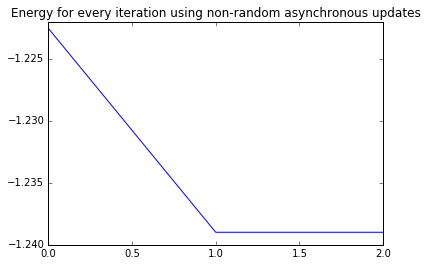

In [31]:
#Non random
plt.plot(energy)
plt.title("Energy for every iteration using non-random asynchronous updates")

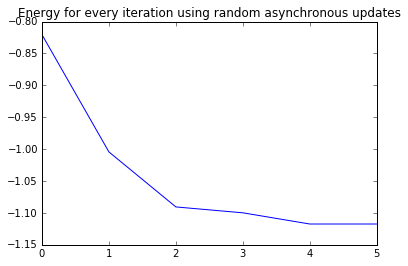

In [32]:
#Random
plt.plot(energy_random)
plt.title("Energy for every iteration using random asynchronous updates")

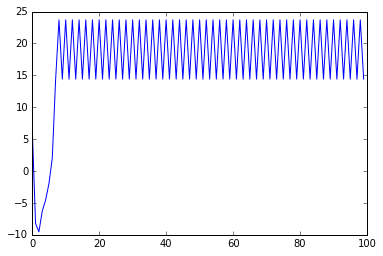

In [55]:
#Generate a weight matrix by setting the weights to normally distributed
#random numbers, and try iterating an arbitrary starting state. What happens?
hn_2 = HebianNet()
dim = 8
hn_2.weights = np.random.randn(dim,dim)
start_state = np.random.randn(8)
recalled, iter_, e = hn.recall(start_state, maxiter = 100)
plt.plot(e)
#Doesn't converge

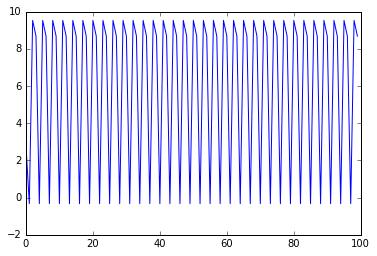

In [56]:
hn_3 = HebianNet()
dim = 8
hn_3.weights = np.random.randn(dim,dim)
hn_3.weights = np.multiply(0.5, hn.weights + np.linalg.inv(hn.weights))
start_state = np.random.randn(8)
recalled, iter_, e = hn.recall(start_state, maxiter = 100)
plt.plot(e)
#Still doesn't really converge?

### Noise Resistance

In [98]:
def distort_data(pattern,percentage):
    dim = pattern.size
    dist = int(dim*percentage)
    subDist = pattern[:dist]
    #print(pattern)
    distPattern=np.copy(pattern)
    np.random.shuffle(distPattern[:dist])    
    return distPattern

#### Attractor 1

original


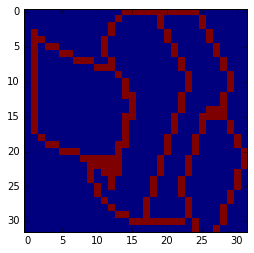

distorting 10.0%


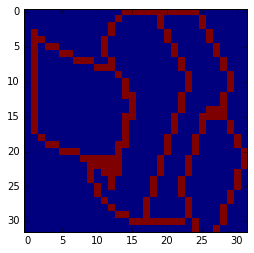

distorting 20.0%


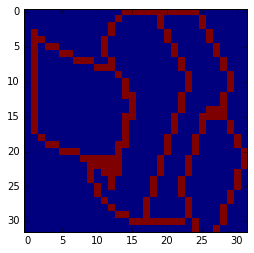

distorting 30.000000000000004%


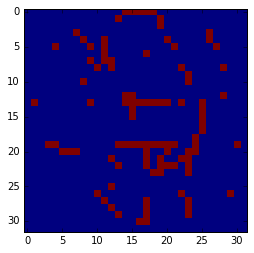

In [137]:
print("original")
hn_cap.plot(trainingData[0])
for percentage in range(3):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[0], percentage)
    recalled, iter_, e = hn.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

In [ ]:
#### Attractor 2

original


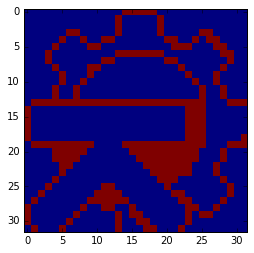

distorting 10.0%


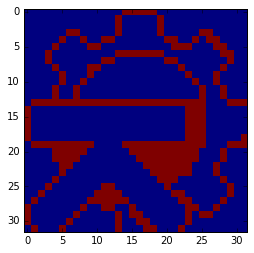

distorting 20.0%


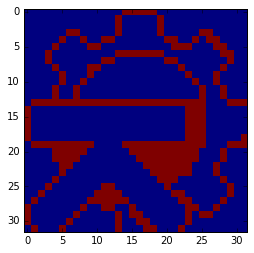

distorting 30.000000000000004%


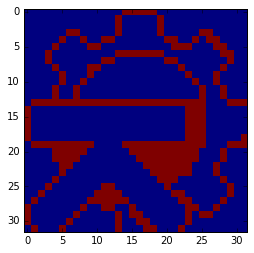

distorting 40.0%


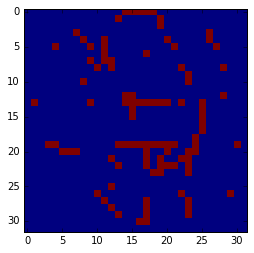

distorting 50.0%


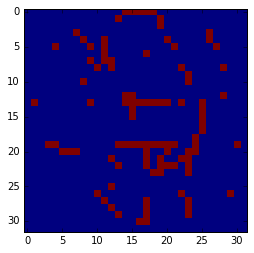

In [136]:
print("original")
hn_cap.plot(trainingData[1])
for percentage in range(5):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[1], percentage)
    recalled, iter_, e = hn.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

#### Attractor 3

original


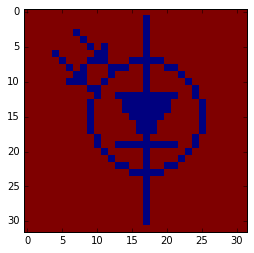

distorting 10.0%


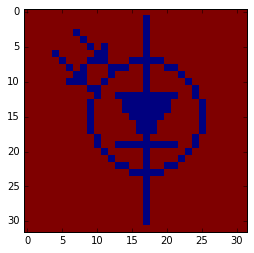

distorting 20.0%


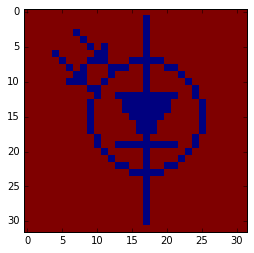

distorting 30.000000000000004%


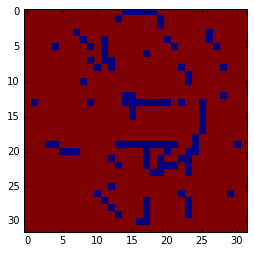

In [135]:
print("original")
hn_cap.plot(trainingData[2])
for percentage in range(3):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[2], percentage)
    recalled, iter_, e = hn.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

### Capacity

In [153]:
def calc_error(pattern):
    recalled = hn_cap.recall(pattern)[0]
    res = np.multiply(recalled, pattern)
    return len(res[res<0])/len(recalled)*100

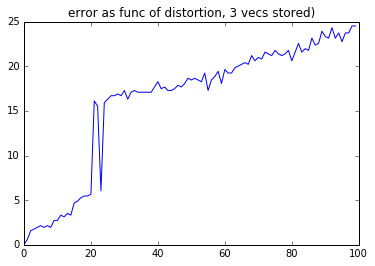

In [232]:
#Train with 3 pics
trainingData = pictData[0:3].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

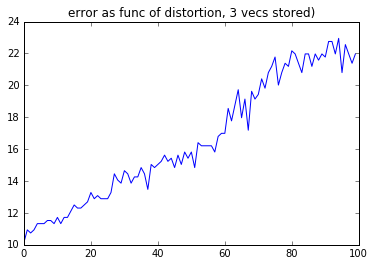

In [233]:
#Train with 4 pics
trainingData = pictData[0:4].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

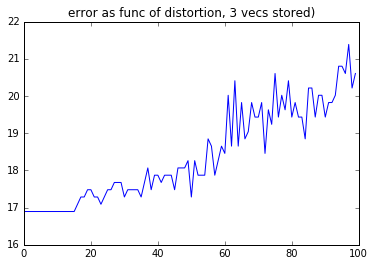

In [234]:
#Train with 5 pics
trainingData = pictData[0:5].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

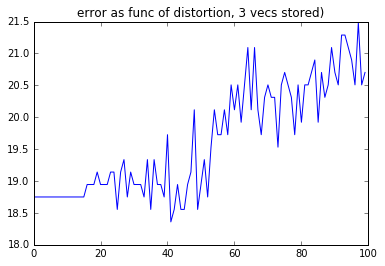

In [235]:
#Train with 6 pics
trainingData = pictData[0:6].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

#### Store random data

In [218]:
def create_random_data(dim):
    training_data = np.random.randn(dim,1024)
    training_data[training_data > 0] = 1
    training_data[training_data <= 0] = -1
    return training_data

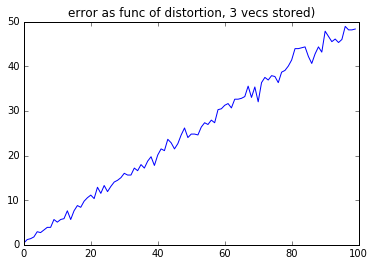

In [231]:
# Store 3 vectors of random data
dim = 3
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

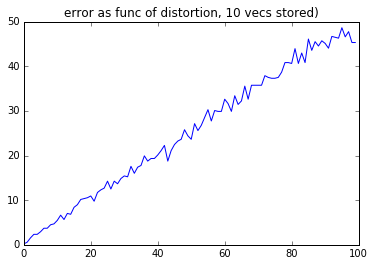

In [230]:
# Store 10 vectors of random data
dim = 10
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

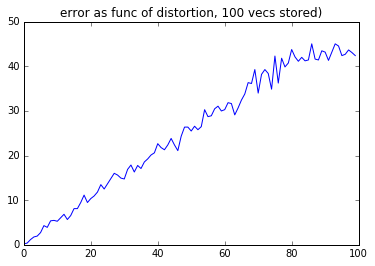

In [229]:
# Store 100 vectors of random data
dim = 100
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

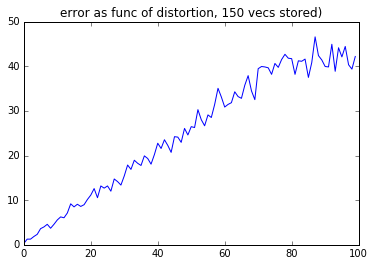

In [228]:
# Store 150 vectors of random data
dim = 150
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

### Sparse Patterns

In [216]:
trainingData.shape

(6, 1024)

#### 10% Acitivity

In [240]:
sparseNet = HebianNet()
sparseNet.sparse_train()